<a href="https://colab.research.google.com/github/fadibechara/MultiGrid/blob/main/Anisotropic_MultiGrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anisotropic multigrid MS HPC-AI 2020-2021

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [44]:
def plot_heatmap(u, n, m):
  u = np.reshape(u, (int(n),int(m)))
  plt.imshow(u, cmap='hot', interpolation='nearest')
  plt.show()

The equation that is taking the form of a matrix vector multiply is :


# ((2/hx²)+(2*ε/hy²))*U(x,y) - (1/hx²)*U(x+h,y) -(ε/hy²)*U(x,y+h) -(1/hx²)*U(x-h,y) -(ε/hy²)U(x,y-h) = f(x,y) 

Where U(x,y) would be a product of the main diagonal componenet of the matrix.

U(x+h,y) and U(x-h,y) are a product of the upper and lower diagonal.
 
Finally U(x,y-h) and U(x,y+h) are respectively products of the diagonals that have strides of -n and +n from the main diagonal.

Thus we are finally left with a sparse **FIVE_DIAGONAL Matrix**

In [45]:
def fivediag(hx, hy, ep):
  n= int(1/hy) + 1
  m= int(1/hx) + 1
  a=[(2/(hx*hx))+(2*ep/(hy*hy))]*(n*m)
  b=[-1/(hx*hx)]*(n*m-1)
  c=[-1/(hx*hx)]*(n*m-1)
  d=[-ep/(hy*hy)]*(n*m-n)
  e=[-ep/(hy*hy)]*(n*m-n)
  A = np.diag(a, 0) + np.diag(b, -1) + np.diag(c, 1) + np.diag(d, -n) + np.diag(e, n)
  A = np.reshape(A, (n*m, n*m))
  return A

In [46]:
def anisotropic_sparse_fivediag(hx, hy, ep):
  A = [(2/(hx*hx))+(2*ep/(hy*hy)), -1/(hx*hx), -ep/(hy*hy)]
  return A

In [47]:
def function(hx,hy):
  n= int(1/hy) + 1
  m= int(1/hx) + 1
  f = np.zeros(n*m, dtype=float)
  n=int(math.sqrt(N))
  for i in range(0,m):
    for j in range(0,n):
       f[i*n+j]=5*hx*hy*i*m*j
  return f


In [48]:
_eps =1e-12
_maxiter=500
def anisotropic_sparse_solver(A, b, x, hx, hy, omega=1.5, eps=_eps, maxiter=_maxiter, sor=1):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)
    n = int(1/hy) + 1
    m = int(1/hx) + 1   
    N = n*m
    if (N != x.size) or (N != b.size):
        raise ArithmeticError("hx and hy values do not correspond to actual discretization")
    residual_history = list()
    disp_history = list()
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
        xn = np.zeros(N)
        for i in range(n+1,N-n-1):  
           s = b[i]
           if (sor==1): s = s - A[2]*xn[i-n] - A[1]*xn[i-1] - A[1]*x[i+1] - A[2]*x[i+n]
           else: s = s - A[2]*x[i-n] - A[1]*x[i-1] - A[1]*x[i+1] - A[2]*x[i+n]
           xn[i]=(1-omega)*x[i]+(omega/(A[0]))*s
        r = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])
        disp = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])
        for i in range(n+2,N-n-1):
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp): disp=dispc
        x = xn[:]
        r = math.sqrt(r)
        disp = math.sqrt(disp)
        residual_history.append(r)
        disp_history.append(disp)
        count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [74]:
def v_anisotropic_multigrid(x, hx, hy, level=3, omega=0.6, ax=2, ay=4):
  start_time = time.time()
  count=0
  nx=1/hx +1
  ny = 1/hy + 1
  while(count<level):
    A = sparse_fivediag(hx,hy, 0.5)
    f = function(1/(nx-1),1/(ny-1))
    x,r,d,c = sparse_solver(A,f,x,hx,hy,0.6,1e-6,10)
    print(c)
    plot_heatmap(x, 1/(hy)+1, 1/(hx)+1)
    x,nx,ny,hx,hy = restrict(x, hx, hy, 2, 4)
    count=count+1

  while(count>0):
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = sparse_fivediag(hx,hy, 0.5)
    f = function(hx,hy)
    if (count!=1):
      x,r,d,c = sparse_solver(A,f,x,hx,hy,0.6,1e-6,100)
    else:
      x,r,d,c = sparse_solver(A,f,x,hx,hy,0.6,1e-6,1)
      print('Final Residual')
      print(r[-1])
    print(x.size)
    print(c)
    plot_heatmap(x, 1/(hy)+1, 1/(hx)+1)
    if(count!=1):
      x,nx,ny,hx,hy = prolongate(x, hy, hx, 4, 2)
    print(x.size)
    count=count-1

  
  elapsed_time = time.time() - start_time
  print('V_MultiGrid Took')
  print(elapsed_time)
  return x

# Anisotropic Restrict

With anisotropic the restrict operator differs from Isotropic in the sense that the x and the y direction have a their own **respective restriction factors**.

In the previous isotropic exercise they were both restricted by the same factor of 2 at every restrict exeution.

Here the x direction can have a restriction factor of say 8 and the y direction can have a factor of 4 for example, that way the discretizations we end up with are rectangular and not squared. 

Thus we can notice differeces in our continuous solution in a more advanced way  than isotropic retrction.

In [50]:
 def restrict(u,hx,hy,ax,ay):
  n= int(1/hy) + 1
  m= int(1/hx) + 1
  Hy=(hy*ay)
  Hx=(hx*ax)
  N= int(1/Hy) + 1
  M= int(1/Hx) + 1
  uc = np.zeros(N*M)
  b = int ((1+ax*hx)*(hx*ax+ax)/(1+hx)/(hx*ax+1))
  c=0
  #the 'c' here is used as a skipping parameter for when i gets halfway through the coarse vector to push it to the other half of the fine vector so we don't get a truncated coarse grid, this is due to the fact that we need to preserve the extremities of the vector to be able to prolongate after restriction
  for i in range(0,M):
   #if (i==int(M/2)): c=((ax-1)*n+ay-1)
   for j in range(0,N):
     uc[i*N+j]=u[i*b*(n)+(j)*(ay)+c]
  return uc,M,N,Hx,Hy




# Anisotropic Prolongation

Concering anisotropic prolongation we have the same dilemma as restriction.

the x direction can be prolongated by a value that is different than the y direction prolongation value.

To be able to do a multigrid cycle the X and Y (ax,ay)restriction values when **restricting down** *should be the same* as the X and Y prolongation(ax,ay)  values when **prolongating up**.

In [67]:
def prolongate(u, hx, hy, ax, ay):
  n = int (1/hy + 1)
  m = int (1/hx + 1)
  Hy = hy/ay
  Hx = hx/ax
  N = int (1/Hy + 1)
  M = int (1/Hx + 1)
  c=0
  uf = np.zeros((N)*(M), dtype=float)
  for i in range(0,M,ax):
    for j in range(0,N,ay):
      uf[i*N+j]=u[int (i*n/ax)+ int (j/ay)]
    for j in range(0,N):
     if ((j%ay)==0):
        c=0
     else:
      c = c + 1
      uf[i*N+j] = uf[i*N+j-c]*(ay-c)/ay + uf[i*N+j-c+ay]*c/ay
  c=0
  for i in range(N,N*M-N-1):
    if ((i%(ax*N))==0):
      c=0
      i=i+N-1
    else:
      if ((i%N)==0): 
        c=c+1
      else:
       uf[i]=(uf[i-c*N]*(ax-c))/ax + uf[i-c*N+ax*N]*c/ax
      
  return uf,M,N,Hx,Hy


In [44]:
e=8
u = np.arange(start=0, stop=4, step=1/2**e, dtype=float)
u.size

1024

In [68]:
e=8
u = np.arange(start=1, stop=524289, step=1, dtype=float)
#u = np.zeros(2**e)  
u.size


524288

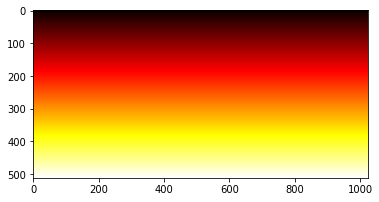

In [69]:
plot_heatmap(u,512,1024)

We will test if in fact our restrictin opeator does what it's supposed to do and succesfully reduces the size along the **X direction by 4** and along the **Y direction by 2.**

In [70]:
u1,m1,n1,hx,hy = restrict(u, 1/(1024-1), 1/(512-1), 2, 4)

We can see that the anisotrpoic restrict operator was succesfful at reducing x and y directions in different values by keeping the same nature of our space.

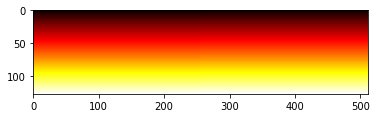

In [71]:
plot_heatmap(u1,n1,m1)

In [72]:
u1,m1,n1,hx,hy = prolongate(u1, 1/(n1-1), 1/(m1-1), 4, 2)

Now that we are sure that the prolongate and restirct methods for anisotropic are working as expected we could go on to the **V multi_grid** methods and examine the benefits it has vs the **regular SOR solver on finegrid.**

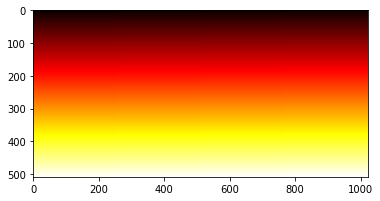

In [73]:
plot_heatmap(u1,m1,n1)